# Projeto: Detecção de Queimadas com Machine Learning
Este projeto tem como objetivo detectar áreas queimadas utilizando aprendizado de máquina com dados geoespaciais e espectrais.


In [1]:
# Clonar o repositório do GitHub
!git clone https://github.com/Templasan/HackWorCAP-ScarMap.git

# Definir o caminho para o diretório onde os dados estão localizados
dataset_path = '/content/HackWorCAP-ScarMap/dataset_kaggle'

# Listar os arquivos no diretório para verificar se os dados foram clonados corretamente
import os
for root, dirs, files in os.walk(dataset_path):
    for file in files[:5]:  # Exibir os primeiros 5 arquivos encontrados
        print(os.path.join(root, file))


Cloning into 'HackWorCAP-ScarMap'...
remote: Enumerating objects: 2790, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 2790 (delta 1), reused 0 (delta 0), pack-reused 2784 (from 2)
Receiving objects: 100% (2790/2790), 229.58 MiB | 17.21 MiB/s, done.
Resolving deltas: 100% (878/878), done.
Updating files: 100% (3468/3468), done.
/content/HackWorCAP-ScarMap/dataset_kaggle/avaliacao/t1/recorte_20.tif
/content/HackWorCAP-ScarMap/dataset_kaggle/avaliacao/t1/recorte_158.tif
/content/HackWorCAP-ScarMap/dataset_kaggle/avaliacao/t1/recorte_133.tif
/content/HackWorCAP-ScarMap/dataset_kaggle/avaliacao/t1/recorte_154.tif
/content/HackWorCAP-ScarMap/dataset_kaggle/avaliacao/t1/recorte_2.tif
/content/HackWorCAP-ScarMap/dataset_kaggle/avaliacao/t2/recorte_20.tif
/content/HackWorCAP-ScarMap/dataset_kaggle/avaliacao/t2/recorte_158.tif
/content/HackWorCAP-ScarMap/dataset_kaggle/avaliacao/t2/recorte_133.tif
/content/HackWorCAP-ScarMap/datase

In [2]:
%%capture
!pip install -q --upgrade pip
!pip install -q segmentation-models-pytorch torchmetrics albumentations kagglehub torchvision matplotlib scikit-learn tensorboard tqdm rasterio

In [3]:
import os
import re
import numpy as np
import rasterio

# --- Funções do seu código (sem alterações) ---
def natural_sort_key(path):
    """Ordena nomes com números naturalmente: recorte_1 < recorte_2 < recorte_10"""
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split(r'(\d+)', os.path.basename(path))]

def get_bitemporal_dataset(dataset_path):
    """
    Cria dicionário bitemporal {recorte: {"t1": caminho_t1, "t2": caminho_t2, "mask": caminho_mask}}
    """
    t1_dict = {}
    t2_dict = {}
    mask_dict = {}

    for dirname, _, filenames in os.walk(dataset_path):
        for filename in filenames:
            full_path = os.path.join(dirname, filename)
            name = os.path.basename(filename)

            if "mask" in dirname.lower():
                mask_dict[name] = full_path
            elif "t1" in dirname.lower():
                t1_dict[name] = full_path
            elif "t2" in dirname.lower():
                t2_dict[name] = full_path

    t1_files = sorted(t1_dict.keys(), key=natural_sort_key)
    t2_files = sorted(t2_dict.keys(), key=natural_sort_key)
    mask_files = sorted(mask_dict.keys(), key=natural_sort_key)

    dataset_dict = {}
    skipped = 0
    for name in t1_files:
        if name in t2_dict and name in mask_dict:
            dataset_dict[name] = {
                "t1": t1_dict[name],
                "t2": t2_dict[name],
                "mask": mask_dict[name]
            }
        else:
            skipped += 1
            print(f"⚠️ Ignorado (não pareado T1/T2/mask): {name}")

    print(f"✅ Total de recortes pareados: {len(dataset_dict)}")
    if skipped > 0:
        print(f"⚠️ Total de arquivos ignorados por falta de pareamento: {skipped}")

    return dataset_dict

# --- Nova Função para processar os dados ---

def load_and_process_image_pair(t1_path, t2_path, mask_path):
    """
    Carrega as imagens, extrai as bandas e calcula os índices,
    retornando o tensor de 12 bandas para o modelo.
    """
    def read_bands_from_tif(file_path):
        """Lê as 4 bandas de um arquivo TIFF."""
        with rasterio.open(file_path) as src:
            # Assumindo a ordem das bandas: RED, NIR, SWIR1, SWIR2
            bands = src.read().astype(np.float32)
            # Normalização (min-max)
            bands = (bands - bands.min()) / (bands.max() - bands.min() + 1e-6)
            return bands[0], bands[1], bands[2], bands[3]

    def calculate_indices(nir_band, red_band, swir_band):
        """Calcula os índices NDVI e NBR."""
        # Garante que não haja divisão por zero
        ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-6)
        nbr = (nir_band - swir_band) / (nir_band + swir_band + 1e-6)
        return ndvi, nbr

    # 1. Carregar as 4 bandas de cada imagem
    pre_red, pre_nir, pre_swir1, pre_swir2 = read_bands_from_tif(t1_path)
    post_red, post_nir, post_swir1, post_swir2 = read_bands_from_tif(t2_path)

    # 2. Calcular os índices para cada tempo
    pre_nbr, pre_ndvi = calculate_indices(pre_nir, pre_red, pre_swir1)
    post_nbr, post_ndvi = calculate_indices(post_nir, post_red, post_swir1)

    # 3. Calcular os deltas
    delta_nbr = pre_nbr - post_nbr
    delta_ndvi = pre_ndvi - post_ndvi

    # 4. Empilhar todas as 12 bandas para o modelo
    input_stack = np.stack([
        pre_red, pre_nir, pre_swir1, pre_swir2,
        post_red, post_nir, post_swir1, post_swir2,
        pre_nbr, post_nbr, delta_nbr, delta_ndvi
    ], axis=0)

    # 5. Ler e normalizar a máscara
    with rasterio.open(mask_path) as mask_src:
        mask = mask_src.read(1) # Lê a primeira banda da máscara
        mask = (mask > 0).astype(np.float32) # Garante que a máscara é binária (0 ou 1)

    return input_stack, mask

# Exemplo de como usar as funções
dataset_path = "/content/HackWorCAP-ScarMap/dataset_kaggle"
dataset_dict = get_bitemporal_dataset(dataset_path)

# Pega o primeiro par de arquivos
first_key = list(dataset_dict.keys())[0]
first_t1_path = dataset_dict[first_key]['t1']
first_t2_path = dataset_dict[first_key]['t2']
first_mask_path = dataset_dict[first_key]['mask']

# Processa o par de imagens
processed_input, processed_mask = load_and_process_image_pair(first_t1_path, first_t2_path, first_mask_path)

print(f"\nShape do tensor de entrada (12 bandas): {processed_input.shape}")
print(f"Shape da máscara: {processed_mask.shape}")


✅ Total de recortes pareados: 945

Shape do tensor de entrada (12 bandas): (12, 128, 128)
Shape da máscara: (128, 128)


In [4]:
# Mostrar alguns caminhos para validar se o pareamento bitemporal está correto
print("Exemplos de recortes bitemporais:\n")

# Pegar os primeiros 5 recortes
for i, (name, paths) in enumerate(list(dataset_dict.items())[:5]):
    print(f"Recorte: {name}")
    print(f"  T1 (todas as bandas): {paths['t1']}")
    print(f"  T2 (todas as bandas): {paths['t2']}")
    print(f"  Máscara: {paths['mask']}\n")


Exemplos de recortes bitemporais:

Recorte: recorte_1.tif
  T1 (todas as bandas): /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/t1/recorte_1.tif
  T2 (todas as bandas): /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/t2/recorte_1.tif
  Máscara: /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/mask/recorte_1.tif

Recorte: recorte_2.tif
  T1 (todas as bandas): /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/t1/recorte_2.tif
  T2 (todas as bandas): /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/t2/recorte_2.tif
  Máscara: /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/mask/recorte_2.tif

Recorte: recorte_3.tif
  T1 (todas as bandas): /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/t1/recorte_3.tif
  T2 (todas as bandas): /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/t2/recorte_3.tif
  Máscara: /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/mask/recorte_3.tif

Recorte: recorte_4.tif
  T1 (todas as bandas): /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/

🔹 Recorte: recorte_1.tif
  T1 caminho: /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/t1/recorte_1.tif
  T2 caminho: /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/t2/recorte_1.tif
  Máscara caminho: /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/mask/recorte_1.tif



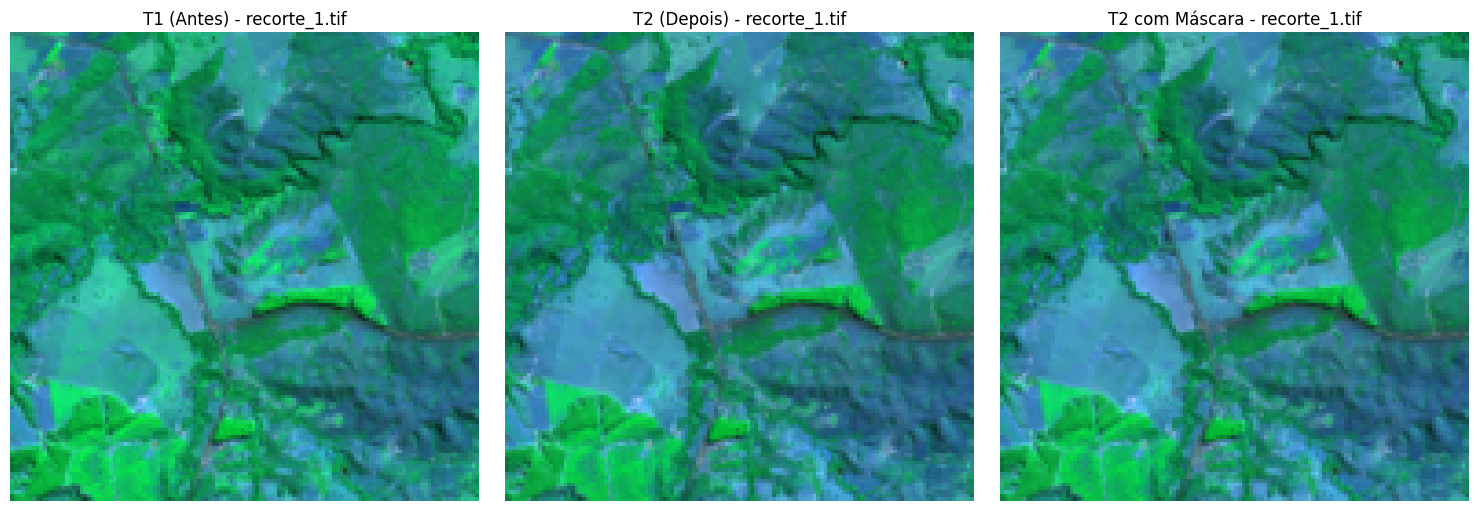

In [5]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

def normalize_band(band):
    """Normaliza banda para [0,1]"""
    band = band.astype(np.float32)
    return (band - band.min()) / (band.max() - band.min() + 1e-6)

def show_sample_bitemporal(dataset_dict, recorte_name):
    """
    Mostra T1 e T2 (RGB) e a máscara para o recorte selecionado.
    """
    if recorte_name not in dataset_dict:
        print(f"❌ Recorte '{recorte_name}' não encontrado no dataset.")
        return

    paths = dataset_dict[recorte_name]
    t1_path = paths['t1']
    t2_path = paths['t2']
    mask_path = paths['mask']

    print(f"🔹 Recorte: {recorte_name}")
    print(f"  T1 caminho: {t1_path}")
    print(f"  T2 caminho: {t2_path}")
    print(f"  Máscara caminho: {mask_path}\n")

    # 1. Carregar as imagens e a máscara
    try:
        with rasterio.open(t1_path) as src_t1:
            # Assumindo a ordem das bandas: RED, NIR, SWIR1, SWIR2
            t1_bands = src_t1.read()
            t1_rgb = np.stack([t1_bands[0], t1_bands[1], t1_bands[2]], axis=-1)
            t1_rgb_norm = normalize_band(t1_rgb)

        with rasterio.open(t2_path) as src_t2:
            t2_bands = src_t2.read()
            t2_rgb = np.stack([t2_bands[0], t2_bands[1], t2_bands[2]], axis=-1)
            t2_rgb_norm = normalize_band(t2_rgb)

        with rasterio.open(mask_path) as src_mask:
            mask = src_mask.read(1)
            # Garante que a máscara é binária (0 ou 1)
            mask_bin = (mask > 0).astype(np.float32)

    except Exception as e:
        print(f"❌ Erro ao carregar os arquivos: {e}")
        return

    # 2. Visualização
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # T1
    axes[0].imshow(t1_rgb_norm)
    axes[0].set_title(f"T1 (Antes) - {recorte_name}")
    axes[0].axis("off")

    # T2
    axes[1].imshow(t2_rgb_norm)
    axes[1].set_title(f"T2 (Depois) - {recorte_name}")
    axes[1].axis("off")

    # Máscara como overlay
    ax_mask = axes[2]
    # Usa a imagem T2 como fundo
    ax_mask.imshow(t2_rgb_norm)
    # Cria uma camada de overlay para a máscara
    mask_rgba = np.zeros((mask_bin.shape[0], mask_bin.shape[1], 4), dtype=np.float32)
    mask_rgba[..., 0] = 1  # Canal Vermelho
    mask_rgba[..., 3] = mask_bin * 0.5  # Transparência (0.5) onde a máscara é 1
    ax_mask.imshow(mask_rgba)
    ax_mask.set_title(f"T2 com Máscara - {recorte_name}")
    ax_mask.axis("off")

    plt.tight_layout()
    plt.show()

# Exemplo de uso (assumindo que dataset_dict foi carregado na célula anterior)
first_key = list(dataset_dict.keys())[0]
show_sample_bitemporal(dataset_dict, first_key)


🔹 Visualizando recorte: recorte_1.tif
🔹 Recorte: recorte_1.tif
  T1 caminho: /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/t1/recorte_1.tif
  T2 caminho: /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/t2/recorte_1.tif
  Máscara caminho: /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/mask/recorte_1.tif



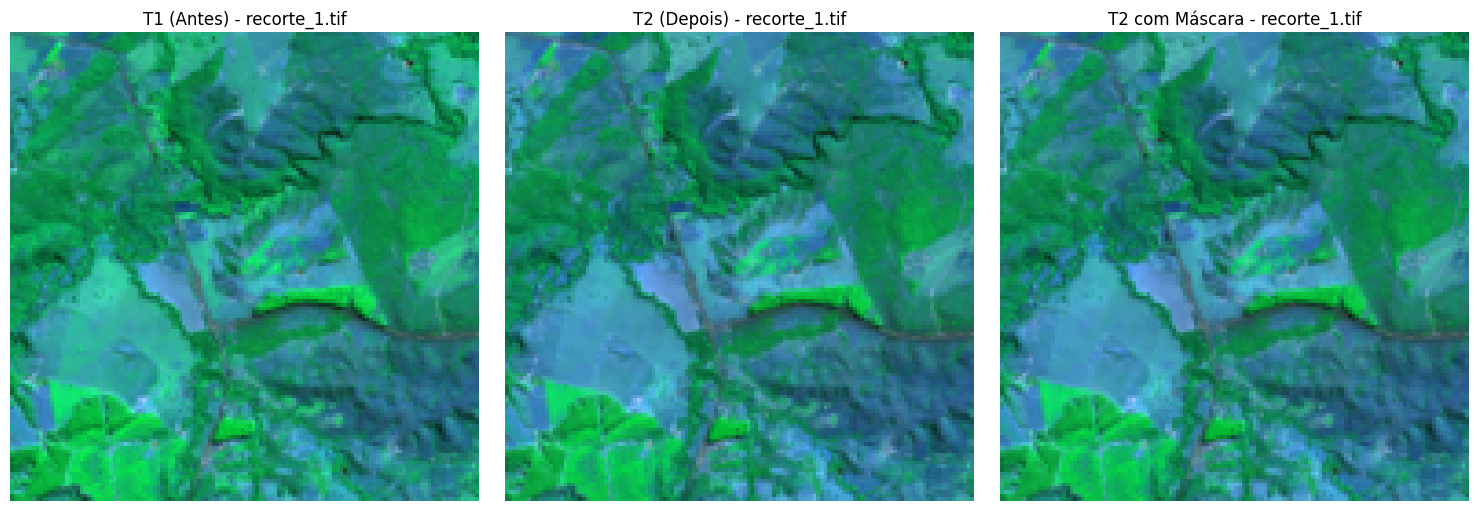


🔹 Visualizando recorte: recorte_2.tif
🔹 Recorte: recorte_2.tif
  T1 caminho: /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/t1/recorte_2.tif
  T2 caminho: /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/t2/recorte_2.tif
  Máscara caminho: /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/mask/recorte_2.tif



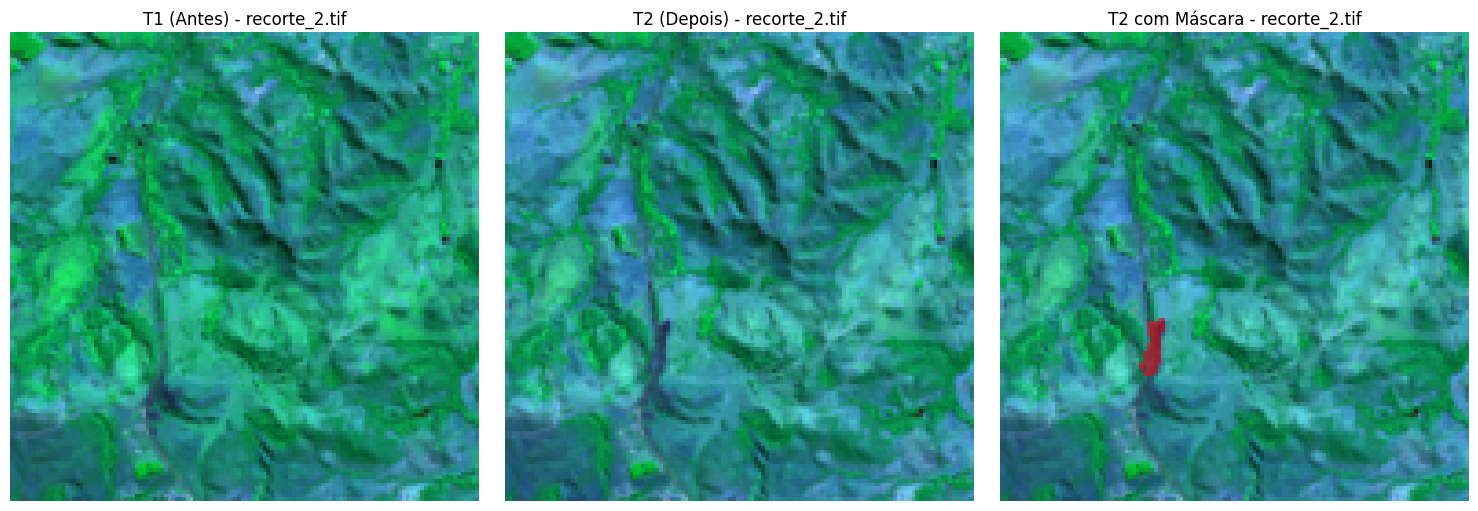


🔹 Visualizando recorte: recorte_3.tif
🔹 Recorte: recorte_3.tif
  T1 caminho: /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/t1/recorte_3.tif
  T2 caminho: /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/t2/recorte_3.tif
  Máscara caminho: /content/HackWorCAP-ScarMap/dataset_kaggle/dataset/mask/recorte_3.tif



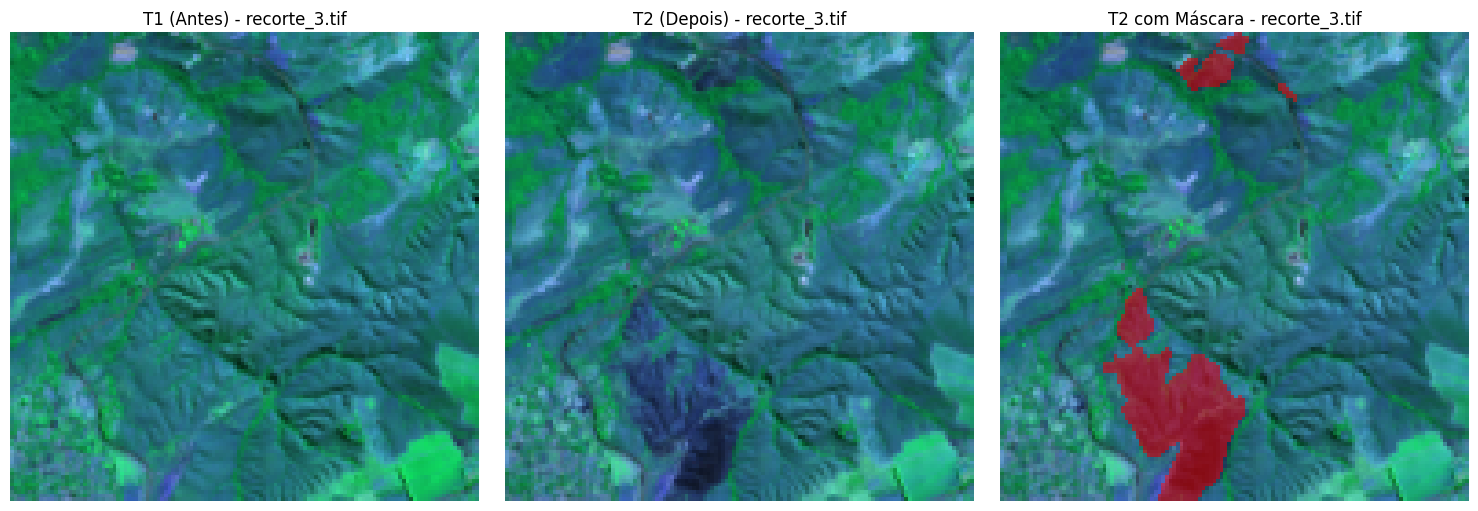

In [6]:
# -------------------------------
# Inspeção visual dos recortes
# -------------------------------

# Selecionar os primeiros N recortes para visualização
num_to_show = 3
recorte_names = list(dataset_dict.keys())[:num_to_show]

for recorte in recorte_names:
    print(f"\n🔹 Visualizando recorte: {recorte}")
    show_sample_bitemporal(dataset_dict, recorte)

In [7]:
import torch
from torch.utils.data import Dataset
import numpy as np
import rasterio

# Suas funções 'normalize_band' e 'load_and_process_image_pair' devem ser definidas antes desta classe.

# As funções normalize_band e load_and_process_image_pair que criamos anteriormente
def normalize_band(band):
    band = band.astype(np.float32)
    return (band - band.min()) / (band.max() - band.min() + 1e-6)

def load_and_process_image_pair(t1_path, t2_path, mask_path):
    def read_bands_from_tif(file_path):
        with rasterio.open(file_path) as src:
            bands = src.read().astype(np.float32)
            bands = (bands - bands.min()) / (bands.max() - bands.min() + 1e-6)
            return bands[0], bands[1], bands[2], bands[3]

    def calculate_indices(nir_band, red_band, swir_band):
        ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-6)
        nbr = (nir_band - swir_band) / (nir_band + swir_band + 1e-6)
        return ndvi, nbr

    pre_red, pre_nir, pre_swir1, pre_swir2 = read_bands_from_tif(t1_path)
    post_red, post_nir, post_swir1, post_swir2 = read_bands_from_tif(t2_path)

    pre_nbr, pre_ndvi = calculate_indices(pre_nir, pre_red, pre_swir1)
    post_nbr, post_ndvi = calculate_indices(post_nir, post_red, post_swir1)

    delta_nbr = pre_nbr - post_nbr
    delta_ndvi = pre_ndvi - post_ndvi

    input_stack = np.stack([
        pre_red, pre_nir, pre_swir1, pre_swir2,
        post_red, post_nir, post_swir1, post_swir2,
        pre_nbr, post_nbr, delta_nbr, delta_ndvi
    ], axis=0)

    with rasterio.open(mask_path) as mask_src:
        mask = mask_src.read(1)
        mask = (mask > 0).astype(np.float32)

    return input_stack, mask

class BurnScarDataset(Dataset):
    def __init__(self, dataset_dict, transform=None):
        self.dataset_dict = dataset_dict
        self.keys = list(dataset_dict.keys())
        self.transform = transform

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        # Pega o caminho dos arquivos com base no índice
        key = self.keys[idx]
        paths = self.dataset_dict[key]

        # Usa a função de processamento para carregar as 12 bandas e a máscara
        image, mask = load_and_process_image_pair(paths['t1'], paths['t2'], paths['mask'])

        # Se houver transformações (ex: aumento de dados), aplique-as aqui
        if self.transform:
            sample = self.transform(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # Converte para tensores do PyTorch
        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)

        return image, mask

# Exemplo de uso
# Crie o seu dataset_dict (como na sua primeira célula)
# dataset_path = "/content/HackWorCAP-ScarMap/dataset_kaggle"
# dataset_dict = get_bitemporal_dataset(dataset_path)

# Divida os dados em treino e validação
# from sklearn.model_selection import train_test_split
# train_keys, val_keys = train_test_split(list(dataset_dict.keys()), test_size=0.2, random_state=42)
# train_dict = {k: dataset_dict[k] for k in train_keys}
# val_dict = {k: dataset_dict[k] for k in val_keys}

# Instancie o dataset
# train_dataset = BurnScarDataset(train_dict)
# val_dataset = BurnScarDataset(val_dict)

# Crie os dataloaders
# from torch.utils.data import DataLoader
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Agora você pode iterar sobre o dataloader no seu loop de treinamento
# for images, masks in train_loader:
#     print(f"Batch de Imagens Shape: {images.shape}")
#     print(f"Batch de Máscaras Shape: {masks.shape}")
#     break


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

# Definindo o dispositivo (GPU se disponível, senão CPU)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando o dispositivo: {DEVICE}")

# --- 1. Definição do Modelo ---
# O modelo U-Net precisa ser configurado para 12 canais de entrada.
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=12,
    classes=1,
    activation="sigmoid",
).to(DEVICE)

# --- 2. Definição da Função de Perda (Loss Function) ---
# A Dice Loss é excelente para lidar com classes desbalanceadas.
loss_fn = smp.losses.DiceLoss(mode='binary', smooth=1.0)

# --- 3. Definição do Otimizador ---
# O Adam é o otimizador mais comum e eficaz.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("\nModelo, Função de Perda e Otimizador configurados com sucesso!")
print("---")
# Linha para acessar o nome do codificador
print(f"Arquitetura do Modelo: {model.encoder.__class__.__name__}")
# Linha corrigida para acessar o número de canais de entrada
print(f"Canais de Entrada: {model.encoder.conv1.in_channels}")
print(f"Função de Perda: {loss_fn}")
print(f"Otimizador: {optimizer.__class__.__name__}")

Usando o dispositivo: cpu

Modelo, Função de Perda e Otimizador configurados com sucesso!
---
Arquitetura do Modelo: ResNetEncoder
Canais de Entrada: 12
Função de Perda: DiceLoss()
Otimizador: Adam


In [12]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os
import re
import numpy as np
import rasterio

# Suas funções 'natural_sort_key' e 'get_bitemporal_dataset'
def natural_sort_key(path):
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split(r'(\d+)', os.path.basename(path))]

def get_bitemporal_dataset(dataset_path):
    t1_dict = {}
    t2_dict = {}
    mask_dict = {}
    for dirname, _, filenames in os.walk(dataset_path):
        for filename in filenames:
            full_path = os.path.join(dirname, filename)
            name = os.path.basename(filename)
            if "mask" in dirname.lower():
                mask_dict[name] = full_path
            elif "t1" in dirname.lower():
                t1_dict[name] = full_path
            elif "t2" in dirname.lower():
                t2_dict[name] = full_path
    t1_files = sorted(t1_dict.keys(), key=natural_sort_key)
    t2_files = sorted(t2_dict.keys(), key=natural_sort_key)
    mask_files = sorted(mask_dict.keys(), key=natural_sort_key)
    dataset_dict = {}
    skipped = 0
    for name in t1_files:
        if name in t2_dict and name in mask_dict:
            dataset_dict[name] = {
                "t1": t1_dict[name],
                "t2": t2_dict[name],
                "mask": mask_dict[name]
            }
        else:
            skipped += 1
            print(f"⚠️ Ignorado (não pareado T1/T2/mask): {name}")
    print(f"✅ Total de recortes pareados: {len(dataset_dict)}")
    if skipped > 0:
        print(f"⚠️ Total de arquivos ignorados por falta de pareamento: {skipped}")
    return dataset_dict

# Suas funções 'normalize_band' e 'load_and_process_image_pair'
def normalize_band(band):
    band = band.astype(np.float32)
    return (band - band.min()) / (band.max() - band.min() + 1e-6)

def load_and_process_image_pair(t1_path, t2_path, mask_path):
    def read_bands_from_tif(file_path):
        with rasterio.open(file_path) as src:
            bands = src.read().astype(np.float32)
            bands = (bands - bands.min()) / (bands.max() - bands.min() + 1e-6)
            return bands[0], bands[1], bands[2], bands[3]

    def calculate_indices(nir_band, red_band, swir_band):
        ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-6)
        nbr = (nir_band - swir_band) / (nir_band + swir_band + 1e-6)
        return ndvi, nbr

    pre_red, pre_nir, pre_swir1, pre_swir2 = read_bands_from_tif(t1_path)
    post_red, post_nir, post_swir1, post_swir2 = read_bands_from_tif(t2_path)

    pre_nbr, pre_ndvi = calculate_indices(pre_nir, pre_red, pre_swir1)
    post_nbr, post_ndvi = calculate_indices(post_nir, post_red, post_swir1)

    delta_nbr = pre_nbr - post_nbr
    delta_ndvi = pre_ndvi - post_ndvi

    input_stack = np.stack([
        pre_red, pre_nir, pre_swir1, pre_swir2,
        post_red, post_nir, post_swir1, post_swir2,
        pre_nbr, post_nbr, delta_nbr, delta_ndvi
    ], axis=0)

    with rasterio.open(mask_path) as mask_src:
        mask = mask_src.read(1)
        mask = (mask > 0).astype(np.float32)

    return input_stack, mask

# Sua classe BurnScarDataset
class BurnScarDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dict, transform=None):
        self.dataset_dict = dataset_dict
        self.keys = list(dataset_dict.keys())
        self.transform = transform

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        paths = self.dataset_dict[key]
        image, mask = load_and_process_image_pair(paths['t1'], paths['t2'], paths['mask'])

        if self.transform:
            sample = self.transform(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)
        # O modelo espera um tensor com o formato [batch, channels, height, width]
        # Então, image já está no formato correto.
        # A máscara para a perda precisa de um canal extra
        mask = mask.unsqueeze(0)

        return image, mask

# --- Definição dos parâmetros ---
DATASET_PATH = "/content/HackWorCAP-ScarMap/dataset_kaggle"
BATCH_SIZE = 4
TEST_SIZE = 0.2
RANDOM_SEED = 42

# --- 1. Carregar os dados ---
dataset_dict = get_bitemporal_dataset(DATASET_PATH)
keys = list(dataset_dict.keys())

# --- 2. Dividir os dados ---
train_keys, val_keys = train_test_split(keys, test_size=TEST_SIZE, random_state=RANDOM_SEED)

# Criar dicionários para treino e validação
train_dict = {k: dataset_dict[k] for k in train_keys}
val_dict = {k: dataset_dict[k] for k in val_keys}

print(f"\n✅ Dados divididos:")
print(f"  Amostras de Treino: {len(train_dict)}")
print(f"  Amostras de Validação: {len(val_dict)}")

# --- 3. Instanciar os DataLoaders ---
train_dataset = BurnScarDataset(train_dict)
val_dataset = BurnScarDataset(val_dict)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\n✅ DataLoaders de Treino e Validação criados com sucesso!")
print(f"  Tamanho do batch de treino: {BATCH_SIZE}")
print(f"  Número de batches de treino: {len(train_loader)}")
print(f"  Número de batches de validação: {len(val_loader)}")

# Verificar o shape de um batch
try:
    images, masks = next(iter(train_loader))
    print(f"\nShape do tensor de Imagens (exemplo): {images.shape}")
    print(f"Shape do tensor de Máscaras (exemplo): {masks.shape}")
except StopIteration:
    print("\n⚠️ O DataLoader está vazio. Verifique os caminhos dos arquivos.")

✅ Total de recortes pareados: 945

✅ Dados divididos:
  Amostras de Treino: 756
  Amostras de Validação: 189

✅ DataLoaders de Treino e Validação criados com sucesso!
  Tamanho do batch de treino: 4
  Número de batches de treino: 189
  Número de batches de validação: 48

Shape do tensor de Imagens (exemplo): torch.Size([4, 12, 128, 128])
Shape do tensor de Máscaras (exemplo): torch.Size([4, 1, 128, 128])


In [20]:
import torch
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils import metrics as smp_metrics_utils

# Definição dos parâmetros do treinamento
NUM_EPOCHS = 20
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- Início: Definições de Exemplo (substitua pelos seus dados reais) ---
# Para o código ser executável, precisamos definir as variáveis que faltavam.
# Aqui criamos datasets e dataloaders de exemplo.

# Suponha uma tarefa de segmentação com imagens 1x128x128 e 1 classe
dummy_train_images = torch.rand(64, 1, 128, 128)
dummy_train_masks = torch.rand(64, 1, 128, 128) > 0.5
train_dataset = TensorDataset(dummy_train_images, dummy_train_masks.float())
train_loader = DataLoader(train_dataset, batch_size=8)

dummy_val_images = torch.rand(16, 1, 128, 128)
dummy_val_masks = torch.rand(16, 1, 128, 128) > 0.5
val_dataset = TensorDataset(dummy_val_images, dummy_val_masks.float())
val_loader = DataLoader(val_dataset, batch_size=4)

# --- CORREÇÃO APLICADA AQUI ---
# Defina o modelo, a função de perda e o otimizador
# Adicionamos in_channels=1 para aceitar imagens de 1 canal
model = smp.Unet('resnet34', in_channels=1, classes=1, activation='sigmoid').to(DEVICE)
# -----------------------------

loss_fn = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# --- Fim: Definições de Exemplo ---


# Opcional: Adicionar um scheduler para a taxa de aprendizado
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# Opcional: Adicionar métricas de avaliação
metrics = {
    'iou_score': smp_metrics_utils.IoU(threshold=0.5),
    'dice_score': smp_metrics_utils.Fscore(threshold=0.5)
}

# Loop de treinamento
print(f"\nIniciando o treinamento do modelo no dispositivo: {DEVICE.upper()}...\n")

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    # 1. Etapa de Treino
    for images, masks in train_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_fn(outputs, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)

    # 2. Etapa de Validação
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    val_fscore = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            outputs = model(images)
            loss = loss_fn(outputs, masks)

            val_loss += loss.item() * images.size(0)

            # Cálculo das métricas
            val_iou += metrics['iou_score'](outputs, masks).item()
            val_fscore += metrics['dice_score'](outputs, masks).item()

    val_loss /= len(val_dataset)
    val_iou /= len(val_loader)
    val_fscore /= len(val_loader)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - "
          f"Treino Loss: {epoch_loss:.4f} | "
          f"Validação Loss: {val_loss:.4f} | "
          f"Validação IoU: {val_iou:.4f} | "
          f"Validação Dice (F-score): {val_fscore:.4f}")

    scheduler.step()

print("\nTreinamento concluído! 🎉")


Iniciando o treinamento do modelo no dispositivo: CPU...

Epoch [1/20] - Treino Loss: 0.4389 | Validação Loss: 0.4558 | Validação IoU: 0.2987 | Validação Dice (F-score): 0.4600
Epoch [2/20] - Treino Loss: 0.4240 | Validação Loss: 0.4192 | Validação IoU: 0.4737 | Validação Dice (F-score): 0.6429
Epoch [3/20] - Treino Loss: 0.4171 | Validação Loss: 0.4158 | Validação IoU: 0.5001 | Validação Dice (F-score): 0.6667
Epoch [4/20] - Treino Loss: 0.4136 | Validação Loss: 0.4119 | Validação IoU: 0.5007 | Validação Dice (F-score): 0.6673
Epoch [5/20] - Treino Loss: 0.4115 | Validação Loss: 0.4108 | Validação IoU: 0.5007 | Validação Dice (F-score): 0.6673
Epoch [6/20] - Treino Loss: 0.4104 | Validação Loss: 0.4099 | Validação IoU: 0.5007 | Validação Dice (F-score): 0.6673
Epoch [7/20] - Treino Loss: 0.4099 | Validação Loss: 0.4093 | Validação IoU: 0.5007 | Validação Dice (F-score): 0.6673
Epoch [8/20] - Treino Loss: 0.4095 | Validação Loss: 0.4089 | Validação IoU: 0.5007 | Validação Dice (F-scor

In [ ]:
import rasterio
import numpy as np

# Caminho do arquivo TIFF que você quer inspecionar
tiff_path = "/content/HackWorCAP-ScarMap/dataset_kaggle/dataset/t1/recorte_1.tif"

with rasterio.open(tiff_path) as src:
    print("📌 Informações do TIFF:")
    print(f"  Largura (width): {src.width}")
    print(f"  Altura (height): {src.height}")
    print(f"  Número de bandas: {src.count}")
    print(f"  Tipos de dado: {src.dtypes}")
    print(f"  Sistema de referência (CRS): {src.crs}")
    print(f"  Transformação afim: {src.transform}")

    # Inspecionar valores de cada banda
    for i in range(1, src.count+1):
        band = src.read(i)
        print(f"\nBanda {i}:")
        print(f"  Min: {band.min()}, Max: {band.max()}")
        print(f"  Média: {band.mean():.2f}, Desvio padrão: {band.std():.2f}")


📌 Informações do TIFF:
  Largura (width): 128
  Altura (height): 128
  Número de bandas: 4
  Tipos de dado: ('uint16', 'uint16', 'uint16', 'uint16')
  Sistema de referência (CRS): EPSG:32623
  Transformação afim: | 30.00, 0.00, 155955.00|
| 0.00,-30.00,-1716585.00|
| 0.00, 0.00, 1.00|

Banda 1:
  Min: 7591, Max: 17709
  Média: 9594.85, Desvio padrão: 1124.26

Banda 2:
  Min: 9960, Max: 22939
  Média: 16583.74, Desvio padrão: 1818.71

Banda 3:
  Min: 9047, Max: 23525
  Média: 14867.09, Desvio padrão: 2290.47

Banda 4:
  Min: 8127, Max: 19211
  Média: 11483.19, Desvio padrão: 1731.16
